<a href="https://colab.research.google.com/github/DAN-MASH/Machine_learning_models/blob/main/knre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kenya Re-insurance Corporation (KNRA) STOCK ANALYSIS AND PREDICTION USING THE RNN-LSTM

Data source: https://www.wsj.com/market-data/quotes/KE/XNAI/KNRE/financials

In [224]:
#get stock data from the Nairobi Stock Exchange
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import urllib.request
import math
import numpy as np
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
# plt.style.use('dark_background')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

<ipython-input-224-c5debff6cab7>:12: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [225]:
url = "/content/drive/MyDrive/Colab Notebooks/knre/HistoricalPrices (4).csv"

In [226]:
data = pd.read_csv(url)

In [227]:
#read a stock data
data.head()

,Date,Open,High,Low,Close,Volume
0,08/28/24,1.20,1.20,1.14,1.19,1092300
1,08/27/24,1.11,1.21,1.11,1.17,2070900
2,08/26/24,1.20,1.20,1.08,1.10,961400
3,08/23/24,1.22,1.22,1.19,1.20,339900
4,08/22/24,1.24,1.24,1.19,1.21,425100


In [228]:
data.shape

(1662, 6)

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1662 non-null   object 
 1    Open    1662 non-null   float64
 2    High    1662 non-null   float64
 3    Low     1662 non-null   float64
 4    Close   1662 non-null   float64
 5    Volume  1662 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 78.0+ KB


In [230]:
#convert the date object to datetime
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-230-0366280ee7bd>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [231]:
#sort the data using the date
#data = data.sort_values(by='Date')
data.sort_values(by='Date',inplace=True)

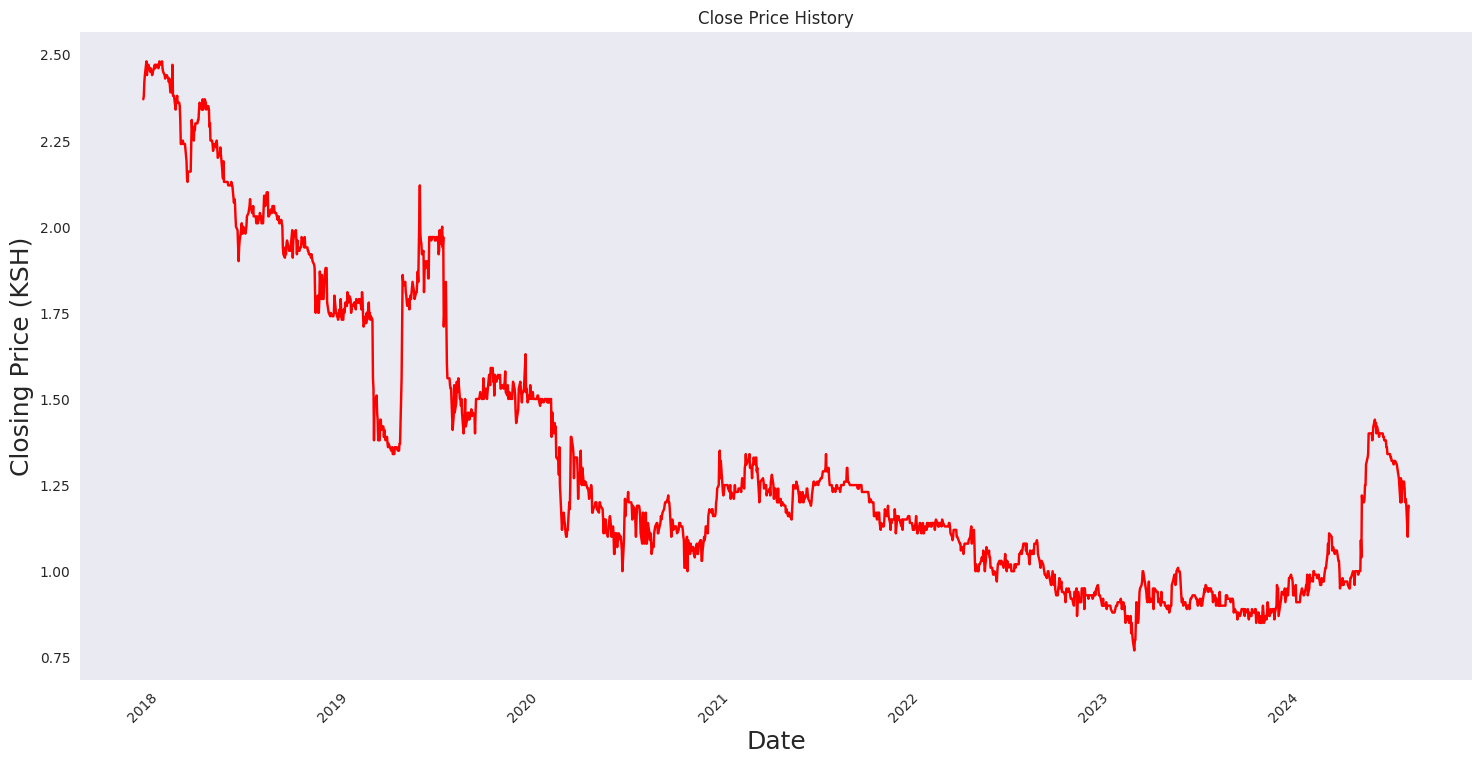

In [232]:
#Close Price History
sns.set_style('darkgrid')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.figure(figsize = (16,8))
plt.plot(data['Date'],data[' Close'],color = 'red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (KSH)',fontsize=18)
plt.title("Close Price History")
plt.grid()
plt.xticks(rotation=45)
#add a dark background to the chart

plt.show()




In [233]:
#make the above graph an interactive graph

import plotly.graph_objects as go

# Create the figure
fig = go.Figure(data=[go.Scatter(x=data['Date'], y=data[' Close'])])

# Customize the layout
fig.update_layout(
    title="Close Price History",
    xaxis_title="Date",
    yaxis_title="Closing Price (KSH)",
    xaxis_rangeslider_visible=True  # Add range slider
)

# Display the interactive plot
fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [234]:
data_2024 = data[data['Date'].dt.year== 2024]

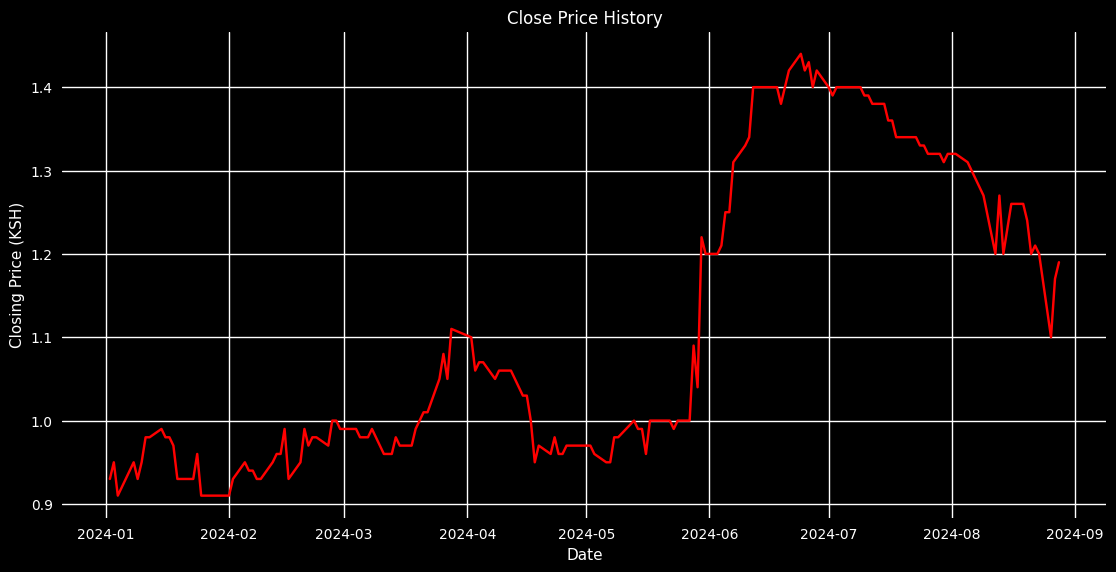

In [235]:
# Plot the filtered data
plt.style.use('dark_background')
plt.figure(figsize = (12,6))
plt.plot(data_2024['Date'], data_2024[' Close'], color='red')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price (KSH)')
#plt.grid()
plt.show()

In [236]:
data.head()

,Date,Open,High,Low,Close,Volume
1661,2018-01-02,2.37,2.44,2.33,2.37,90400
1660,2018-01-03,2.38,2.44,2.38,2.38,24800
1659,2018-01-04,2.42,2.44,2.37,2.42,10731200
1658,2018-01-05,2.44,2.50,2.41,2.44,7071200
1657,2018-01-08,2.48,2.50,2.44,2.48,15200


In [237]:
data.shape

(1662, 6)

In [238]:
#create a new dataframe with only the close column
df = data.filter([' Close'])
#convert the dataframe to numpy array
dataset = df.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)


In [239]:
training_data_len

1330

In [240]:
dataset

array([[2.37],
       [2.38],
       [2.42],
       ...,
       [1.1 ],
       [1.17],
       [1.19]])

In [241]:
#scale the data by applying preprocessing transformations/normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.93567251],
       [0.94152047],
       [0.96491228],
       ...,
       [0.19298246],
       [0.23391813],
       [0.24561404]])

In [256]:
#train the data using the last 650 days
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x_train and y_train
X_train = []
y_train = []
for i in range(650, len(train_data)):
  X_train.append(train_data[i-650:i,0])
  y_train.append(train_data[i,0])
  if i<=650:
    print(X_train)
    print(y_train)
    print()

[array([0.93567251, 0.94152047, 0.96491228, 0.97660819, 1.        ,
       0.97660819, 0.99415205, 0.99415205, 0.99415205, 0.98245614,
       0.98830409, 0.98245614, 0.98245614, 0.97660819, 0.98830409,
       0.98830409, 0.99415205, 0.98830409, 0.99415205, 0.99415205,
       0.99415205, 0.98830409, 0.99415205, 1.        , 0.99415205,
       0.99415205, 1.        , 0.98830409, 0.98245614, 0.97660819,
       0.97076023, 0.97660819, 0.97660819, 0.97660819, 0.97076023,
       0.96491228, 0.97076023, 0.95906433, 0.94736842, 0.94736842,
       0.99415205, 0.94152047, 0.94152047, 0.94152047, 0.91812865,
       0.92982456, 0.93567251, 0.94152047, 0.92982456, 0.92982456,
       0.92397661, 0.9005848 , 0.85964912, 0.85964912, 0.86549708,
       0.85964912, 0.85964912, 0.85964912, 0.85964912, 0.83040936,
       0.80116959, 0.79532164, 0.8128655 , 0.8128655 , 0.85380117,
       0.9005848 , 0.88304094, 0.86549708, 0.88888889, 0.88304094,
       0.89473684, 0.89473684, 0.89473684, 0.9005848 , 0.9005

In [243]:
#convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [244]:
X_train.shape

(680, 650)

In [245]:
#reshape the data into 3D: samples,time steps, features
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(680, 650, 1)

In [246]:
#build the lstm model
model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(70, return_sequences=False))
model.add(Dense(35))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [248]:
# # This code defines a sequential model for a Long Short-Term Memory (LSTM) neural network.
#
# # 1. `model = Sequential()`: This line creates an instance of a sequential model.
# #    Sequential models are linear stacks of layers.
#
# # 2. `model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))`: This adds the first LSTM layer.
# #    - `LSTM(50)`: This specifies that the LSTM layer has 50 memory cells.
# #    - `return_sequences=True`: This indicates that the layer should return the full sequence of outputs, not just the last output. This is important for stacking LSTM layers.
# #    - `input_shape=(X_train.shape[1],1)`: This defines the shape of the input data.
# #      - `X_train.shape[1]` is the number of time steps in your input data (the length of the sequence).
# #      - `1` indicates that there is one feature (in this case, the closing price).
#
# # 3. `model.add(LSTM(50, return_sequences=False))`: This adds a second LSTM layer.
# #    - `return_sequences=False`: This means that this layer will only return the last output in the sequence.
#
# # 4. `model.add(Dense(25))`: This adds a dense layer with 25 neurons. Dense layers connect every neuron in the previous layer to every neuron in the current layer.
#
# # 5. `model.add(Dense(1))`: This adds the final output layer with one neuron. This neuron will predict the closing price.
#build the lstm model


# New Section


In [249]:
#compile te model
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

In [250]:
#train the model
model.fit(X_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 242s 353ms/step - accuracy: 0.0017 - loss: 0.0020
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 261s 351ms/step - accuracy: 7.9696e-05 - loss: 4.9882e-04
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 259s 347ms/step - accuracy: 0.0029 - loss: 3.7253e-04
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 236s 348ms/step - accuracy: 2.1545e-04 - loss: 3.3248e-04
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 262s 348ms/step - accuracy: 0.0012 - loss: 3.6773e-04
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 262s 347ms/step - accuracy: 0.0016 - loss: 2.7201e-04
Epoch 7/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 264s 350ms/step - accuracy: 9.5561e-04 - loss: 3.2136e-04
Epoch 8/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 264s 354ms/step - accuracy: 1.8826e-04 - loss: 2.6887e-04
Epoch 9/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 261s 352ms/step - accuracy: 8.7524e-04 - loss: 2.9688e-04
Epoch 10/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 262s 353ms/step - accuracy: 0.0013 - loss: 3.0988e-04


In [257]:
#creating test dataset
test_data = scaled_data[training_data_len-650:,:]
#get the X_test,y_test
X_test = []
y_test = []
for i in range(650, len(test_data)):
  X_test.append(test_data[i-650:i,0])
  y_test.append(test_data[i,0])
  # if i<=642:
  #   print(X_test)
  #   print(y_test)
  #   print()

In [258]:
X_test = np.array(X_test)


In [259]:
#reshape the x_test
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(332, 650, 1)

In [260]:
#get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


In [261]:
#Evaluate the model using the root mean squared error rmse
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.8747836897760064

In [262]:
#Evaluate the model using the root mean squared error rmse
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"r2 : {mse}")


Mean Squared Error: 0.7683321652656129
Mean Absolute Error: 0.8747836897760066
r2 : 0.7683321652656129


<ipython-input-263-76229694957f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



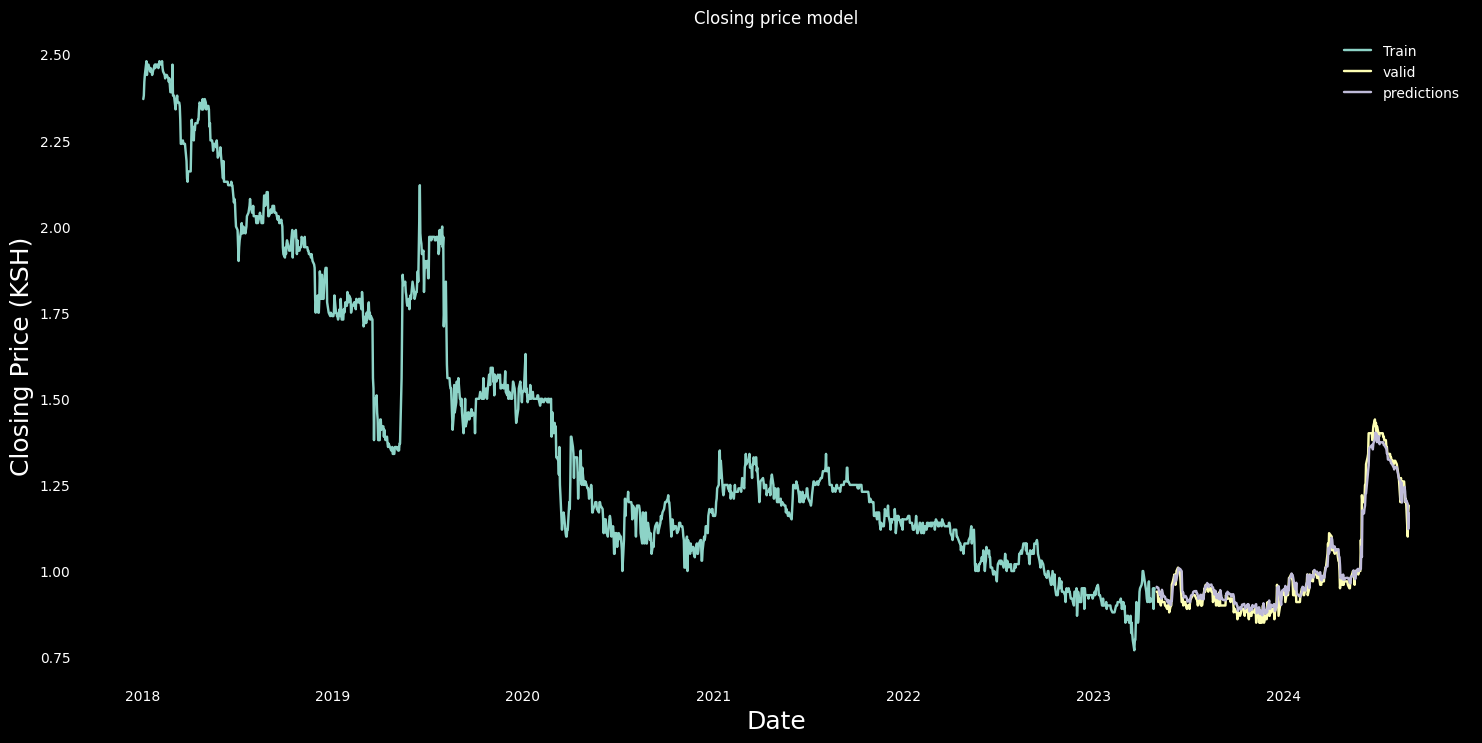

In [263]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions
plt.figure(figsize = (16,8))
plt.plot(train['Date'],train[' Close'])
plt.plot(valid['Date'],valid[[' Close','predictions']])
plt.legend(['Train','valid','predictions'],loc='upper right')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (KSH)',fontsize=18)
plt.title("Closing price model")
plt.grid()
#add a dark background to the chart

plt.show()


In [264]:
valid

,Date,Open,High,Low,Close,Volume,predictions
331,2023-05-02,0.95,0.97,0.93,0.94,59800,0.954257
330,2023-05-03,0.97,0.97,0.92,0.94,181400,0.951329
329,2023-05-04,0.93,0.96,0.91,0.94,78000,0.951655
328,2023-05-05,0.93,0.94,0.88,0.91,509600,0.951442
327,2023-05-08,0.94,0.97,0.90,0.92,449000,0.930710
...,...,...,...,...,...,...,...
4,2024-08-22,1.24,1.24,1.19,1.21,425100,1.200927
3,2024-08-23,1.22,1.22,1.19,1.20,339900,1.205952
2,2024-08-26,1.20,1.20,1.08,1.10,961400,1.195149
1,2024-08-27,1.11,1.21,1.11,1.17,2070900,1.121723


In [273]:
fig = go.Figure(data=[go.Scatter(x=train['Date'], y=train[' Close'],name='Train'),
                      go.Scatter(x=valid['Date'], y=valid[' Close'], name='Valid'),
                      go.Scatter(x=valid['Date'], y=valid['predictions'], name='Predictions')])
# plt.plot(train['Date'],train[' Close'])
# plt.plot(valid[[' Close','predictions']]))
#plt.plot(valid['Date'],valid[' Close'])
#plt.plot(valid['Date'],valid['predictions'])
# Customize the layout
fig.update_layout(
    title="Close Price History",
    xaxis_title="Date",
    yaxis_title="Closing Price (KSH)",
xaxis_rangeslider_visible=True,  # Add range slider
    xaxis_tickformat='%Y-%m-%d',
)

# Display the interactive plot
#plt.legend(['Train','valid','predictions'],loc='upper right')
fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# #create a new dataframe with only the close column
# df = data.filter([' Close'])
# #convert the dataframe to numpy array
# dataset = df.values

# # Filter data for 2024
# data_2024 = data[data['Date'].dt.year == 2024]
# df_2024 = data_2024.filter([' Close'])
# dataset_2024 = df_2024.values

# #get the number of rows to train the model on
# training_data_len = math.ceil(len(dataset_2024)*0.8)

# training_data_len
# dataset
# #scale the data by applying preprocessing transformations/normalization
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(dataset_2024)
# scaled_data

# #train the data using the last 641 days
# #create the training dataset
# #create the scaled training dataset
# train_data = scaled_data[0:training_data_len, :]
# #split the data into x_train and y_train
# X_train = []
# y_train = []
# for i in range(63, len(train_data)):
#   X_train.append(train_data[i-63:i,0])
#   y_train.append(train_data[i,0])
#   if i<=63:
#     print(X_train)
#     print(y_train)
#     print()
# #convert the X_train and y_train to numpy array
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train.shape
# #reshape the data into 3D: samples,time steps, features
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
# X_train.shape
# # # This code defines a sequential model for a Long Short-Term Memory (LSTM) neural network.
# #
# # # 1. `model = Sequential()`: This line creates an instance of a sequential model.
# # #    Sequential models are linear stacks of layers.
# #
# # # 2. `model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))`: This adds the first LSTM layer.
# # #    - `LSTM(50)`: This specifies that the LSTM layer has 50 memory cells.
# # #    - `return_sequences=True`: This indicates that the layer should return the full sequence of outputs, not just the last output. This is important for stacking LSTM layers.
# # #    - `input_shape=(X_train.shape[1],1)`: This defines the shape of the input data.
# # #      - `X_train.shape[1]` is the number of time steps in your input data (the length of the sequence).
# # #      - `1` indicates that there is one feature (in this case, the closing price).
# #
# # # 3. `model.add(LSTM(50, return_sequences=False))`: This adds a second LSTM layer.
# # #    - `return_sequences=False`: This means that this layer will only return the last output in the sequence.
# #
# # # 4. `model.add(Dense(25))`: This adds a dense layer with 25 neurons. Dense layers connect every neuron in the previous layer to every neuron in the current layer.
# #
# # # 5. `model.add(Dense(1))`: This adds the final output layer with one neuron. This neuron will predict the closing price.
# #build the lstm model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))
# #compile te model
# model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
# #train the model
# model.fit(X_train,y_train, batch_size=1, epochs=10)
# #creating test dataset
# test_data = scaled_data[training_data_len-64:,:]
# #get the X_test,y_test
# X_test = []
# y_test = []
# for i in range(64, len(test_data)):
#   X_test.append(test_data[i-64:i,0])
#   y_test.append(test_data[i,0])
#   # if i<=642:
#   #   print(X_test)
#   #   print(y_test)
#   #   print()
# X_test = np.array(X_test)

# #reshape the x_test
# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# X_test.shape
# #get the models predicted price values
# predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
# #Evaluate the model using the root mean squared error rmse
# rmse = np.sqrt(np.mean(predictions-y_test)**2)
# rmse
# #Evaluate the model using the root mean squared error rmse
# mse = mean_squared_error(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)
# r2 = r2_score(y_test, predictions)
# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")
# print(f"r2 : {mse}")

# #plot the data
# train = data_2024[:training_data_len]
# valid = data_2024[training_data_len:]
# valid['predictions'] = predictions
# plt.figure(figsize = (16,8))
# plt.plot(train['Date'],train[' Close'])
# plt.plot(valid['Date'],valid[[' Close','predictions']])
# plt.legend(['Train','valid','predictions'],loc='upper right')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Closing Price (KSH)',fontsize=18)
# plt.title("Closing price model")
# plt.grid()
# #add a dark background to the chart

# plt.show()

# valid
